In [1]:
from scipy.io import netcdf
import numpy
import netCDF4
import pandas
import aacgmv2
import xarray
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from matplotlib.ticker import FuncFormatter, MaxNLocator
from davitpy import utils
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
ampFName = "../data/20110516.0000.86400.120.north.grd.ncdf"
startDate = datetime.datetime( 2011, 5, 16, 8, 0 )
selDate = datetime.datetime( 2011, 5, 16, 8, 20 )
endDate = datetime.datetime( 2011, 5, 16, 9, 0 )
delTime = datetime.timedelta(minutes=10)
coords = "mlt"
# Max latitude at which you expect 
# to find downward FACs associated with SCW
cutOffDownSCWMlat = 60. 

In [3]:
dsXarr = xarray.open_dataset(ampFName)
ampDF = dsXarr.to_dataframe()
ampDF["start_date"] = pandas.to_datetime( dict(year=ampDF.start_yr,\
                    month=ampDF.start_mo, day=ampDF.start_dy,\
                    hour=ampDF.start_hr, minute=ampDF.start_mt,\
                    second=ampDF.start_sc))
ampDF["end_date"] = pandas.to_datetime( dict(year=ampDF.end_yr,\
                    month=ampDF.end_mo, day=ampDF.end_dy,\
                    hour=ampDF.end_hr, minute=ampDF.end_mt,\
                    second=ampDF.end_sc))
ampDF["mlat"] = 90. - ampDF["colat"]
selCols = ['start_date', 'end_date', 'mlat',\
           'mlt', 'dBnorth1', 'dBeast1',\
       'dBnorth2', 'dBeast2', 'dBr', 'Jr']
ampDF = ampDF[selCols].reset_index(drop=True)

ampDF.head()

,start_date,end_date,mlat,mlt,dBnorth1,dBeast1,dBnorth2,dBeast2,dBr,Jr
0,2011-05-16,2011-05-16 00:10:00,89.0,0.0,82.529999,60.080002,76.720001,67.349998,-2.50,-0.21
1,2011-05-16,2011-05-16 00:10:00,88.0,0.0,80.660004,31.370001,76.199997,41.020000,-2.55,-0.27
2,2011-05-16,2011-05-16 00:10:00,87.0,0.0,61.980000,1.050000,61.169998,10.080000,4.62,-0.28
3,2011-05-16,2011-05-16 00:10:00,86.0,0.0,32.880001,-19.570000,35.610001,-13.990000,13.99,-0.25
4,2011-05-16,2011-05-16 00:10:00,85.0,0.0,9.180000,-25.520000,13.440000,-23.559999,22.02,-0.18


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


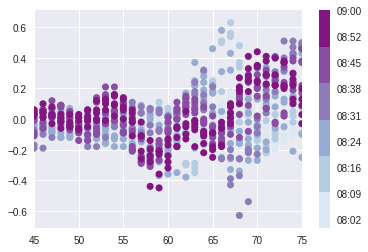

In [4]:
seaMap = ListedColormap(sns.color_palette("BuPu"))
selMlt = 22.

fig = plt.figure()
ax = fig.add_subplot(111)

selDF = ampDF[ ((ampDF["start_date"] >= startDate) & (ampDF["start_date"] <= endDate) &\
                    (ampDF["mlt"] == selMlt) & (numpy.abs(ampDF["Jr"])>=0.)) ]
selDF["time"] = [ date2num(x) for x in selDF["start_date"] ]#selDF["start_date"].map(lambda x:(x.hour + x.minute/60.)*100)
smap = ax.scatter(selDF['mlat'],selDF['Jr'],s=50,c=selDF['time'],
                  edgecolors='none', marker='o', cmap=seaMap) 
ax.set_xlim( [45, 75] )
cb = fig.colorbar(smap, orientation='vertical')
# ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
cb.formatter = DateFormatter('%H:%M')
cb.update_ticks()
# cb.ax.set_yticklabels(set([ x.strftime('%H:%M') for x in selDF['start_date'] ]))
fig.savefig( "../plots/mltAmpTime.pdf",bbox_inches='tight' )

In [15]:
seaMap = ListedColormap(sns.color_palette("BuPu"))
# Isolate SCW!!!
# Set some cutoffs
# SCW MLTs
# Need a trend! Atleast a crude one.
mltSCWList = [ 21., 22., 23., 0. ]
# jr Cutoff
jrSCWCutoff = 0.1
# MLAT Limit
mlatSCWRng = [ 50., 70. ]

# We'll take a simple approach to determine 
# We'll determine the largest positive current
# value between 50 and 70 MLAT (at a few selected
# MLTs). This should be upward R2 FAC. Then largest 
# downward FAC equatorward of this value is the peak
# of downward component of the SCW!
currDate = startDate
while currDate <= endDate:
    for cMlt in mltSCWList:
        selDF = ampDF[ ( (ampDF["start_date"] == currDate) &\
                        (numpy.abs(ampDF["Jr"])>=jrSCWCutoff) &\
                       (ampDF["mlt"] == cMlt) &\
                   (ampDF["mlat"] >= mlatSCWRng[0]) &\
                        (ampDF["mlat"] <= mlatSCWRng[1])) ]\
                [ ["start_date", "mlat", "mlt", "Jr"] ].reset_index(drop=True)
        if currDate == selDate:
            print currDate, cMlt
            maxUpJrMlt = selDF.ix[ selDF["Jr"].idxmax() ]["mlt"]
            maxUpJrMlat = selDF.ix[ selDF["Jr"].idxmax() ]["mlat"]
            maxUpJrVal = selDF.ix[ selDF["Jr"].idxmax() ]["Jr"]
            print "---------------------------"
            print maxUpJrMlt,maxUpJrMlat,maxUpJrVal
            scwDownDF = selDF[ selDF["mlat"] < maxUpJrMlat ]
            maxDownSCWMlat = scwDownDF.ix[ scwDownDF["Jr"].idxmin() ]["mlat"]
            maxDownSCWJr = scwDownDF.ix[ scwDownDF["Jr"].idxmin() ]["Jr"]
            maxDownSCWMlt = scwDownDF.ix[ scwDownDF["Jr"].idxmin() ]["mlt"]
            print "----------------------------------------------------------"
            if maxDownSCWJr > 0.:
                print "postive val found for Jscw down, discarding!"
                continue
            if maxDownSCWMlat < cutOffDownSCWMlat :
                print "downward scw FACs location may not be good, skipping"
                continue
            print maxDownSCWMlt,maxDownSCWMlat,maxDownSCWJr
    currDate += delTime

2011-05-16 08:20:00 21.0
---------------------------
21.0 67.0 1.41
----------------------------------------------------------
21.0 63.0 -1.17
2011-05-16 08:20:00 22.0
---------------------------
22.0 66.0 0.58
----------------------------------------------------------
22.0 62.0 -0.38
2011-05-16 08:20:00 23.0
---------------------------
23.0 61.0 0.35
----------------------------------------------------------
downward scw FACs location may not be good, skipping
2011-05-16 08:20:00 0.0
---------------------------
0.0 62.0 0.57
----------------------------------------------------------
postive val found for Jscw down, discarding!


In [6]:
# fig = plt.figure()
# ax = fig.add_subplot(111)

# selDF["time"] = [ date2num(x) for x in selDF["start_date"] ]#selDF["start_date"].map(lambda x:(x.hour + x.minute/60.)*100)
# smap = ax.scatter(selDF['mlat'],selDF['Jr'],s=5,c=selDF['time'],
#                   edgecolors='none', marker='o', cmap=seaMap)
# ax.set_xlim( [45, 75] )
# ax.set_ylim( [-0.5, 0.5] )
# cb = fig.colorbar(smap, orientation='vertical')
# # ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
# cb.formatter = DateFormatter('%H:%M')
# cb.update_ticks()
# # cb.ax.set_yticklabels(set([ x.strftime('%H:%M') for x in selDF['start_date'] ]))
# fig.savefig( "../plots/scwAmpTime.pdf",bbox_inches='tight' )